### Agent-Lab: Adaptive RAG Agent

Objective of this notebook is evaluating and adapting the implementation of [Adaptive RAG Agent](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/).

#### Preparation steps:

Before executing the notebook perform the following preparation steps.

1. Start Docker containers: `docker compose up -d --build`

2. Verify application is up and running, with web browser: `http://localhost:18000/docs`

3. Inside project root directory, create a `.env` file with env vars with correct values:

    ```
    OLLAMA_ENDPOINT="http://localhost:11434"
    OLLAMA_MODEL_TAG="mistral-small:24b"
    XAI_API_KEY="???"
    XAI_MODEL_TAG="grok-2-1212"
    ```

---

In [1]:
%%capture

import os
os.chdir('..')

from dotenv import load_dotenv
load_dotenv()

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest


# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
# agent_id = experiment_utils.create_ollama_agent(
#     agent_type="adaptive_rag",
#     llm_tag="llama3.2-vision:latest",
#     ollama_endpoint=os.getenv("OLLAMA_ENDPOINT")
#)

agent_id = experiment_utils.create_xai_agent(
    agent_type="adaptive_rag",
    llm_tag=os.getenv("XAI_MODEL_TAG"),
    api_key=os.getenv("XAI_API_KEY")
)

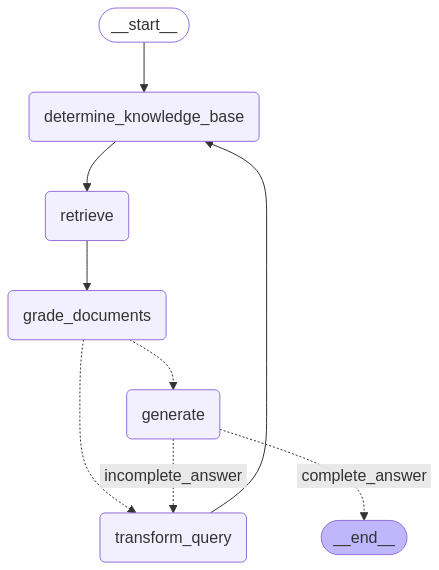

In [3]:
# get agent instance
adaptive_rag_agent = container.adaptive_rag_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# Create Graph
workflow_builder = adaptive_rag_agent.get_workflow_builder(agent_id)
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

In [4]:
agent_config = {
    "configurable": {
        "thread_id": agent_id,
    },
    "recursion_limit": 30
}

In [5]:
%%capture

message_content = (
    "You have access to this book 'The Art of War - Sun Tzu' available at static_document_data, "
    "According to the book, what is the pinnacle of excellence? "
)

message = MessageRequest(
    message_role="human",
    message_content=message_content,
    agent_id=agent_id
)

inputs = adaptive_rag_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [6]:
print(result['generation'])

According to 'The Art of War' by Sun Tzu, the pinnacle of excellence is to subdue the enemy without fighting.


In [7]:
%%capture

message_content = (
    "Can you repeat my previous question about the art of war and answer it again but this time in dutch?"
)

message = MessageRequest(
    message_role="human",
    message_content=message_content,
    agent_id=agent_id
)

inputs = adaptive_rag_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [8]:
print(result['generation'])

Uw vorige vraag was: 'Volgens het boek 'De Kunst van het Oorlogvoeren - Sun Tzu', wat is de hoogste vorm van uitmuntendheid?' Het antwoord daarop is: Volgens 'De Kunst van het Oorlogvoeren' van Sun Tzu is de hoogste vorm van uitmuntendheid om de vijand te onderwerpen zonder te vechten.


In [9]:
%%capture

message_content = (
    "Kun je mijn vorige vraag en jouw antwoord herhalen maar dit keer in het Portugees?"
)

message = MessageRequest(
    message_role="human",
    message_content=message_content,
    agent_id=agent_id
)

inputs = adaptive_rag_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [10]:
print(result['generation'])

Sua pergunta anterior foi: 'De acordo com o livro 'A Arte da Guerra - Sun Tzu', qual é o ápice da excelência?' A resposta para isso é: De acordo com 'A Arte da Guerra' de Sun Tzu, o ápice da excelência é subjugar o inimigo sem lutar.


In [11]:
print(f"\nMessage history as chain-of-thought:")
count = 0
for message in result['messages']:
    count+=1
    print(f"\n---\n#{count}:\n{message}")


Message history as chain-of-thought:

---
#1:
First: The human asked or stated - You have access to this book 'The Art of War - Sun Tzu' available at static_document_data, According to the book, what is the pinnacle of excellence? 
Then: The AI responded with - According to 'The Art of War' by Sun Tzu, the pinnacle of excellence is to subdue the enemy without fighting.
Connection: According to 'The Art of War' by Sun Tzu, the pinnacle of excellence is to subdue the enemy without fighting. This concept is not directly mentioned in the provided context, but it is a well-known principle from the book.

---
#2:
First: The human asked or stated - Can you repeat my previous question about the art of war and answer it again but this time in dutch?
Then: The AI responded with - Uw vorige vraag was: 'Volgens het boek 'De Kunst van het Oorlogvoeren - Sun Tzu', wat is de hoogste vorm van uitmuntendheid?' Het antwoord daarop is: Volgens 'De Kunst van het Oorlogvoeren' van Sun Tzu is de hoogste vo